In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import urllib.request
import os

base_url = 'http://download.tensorflow.org/models/object_detection/'
file_name = 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz'

url = base_url + file_name

urllib.request.urlretrieve(url, file_name)

os.listdir()

['.config',
 'trashnet.zip',
 'labels.txt',
 'bottles.zip',
 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz',
 'sample_data']

In [0]:
import tarfile
import shutil

dir_name = file_name[0:-len('.tar.gz')]

if os.path.exists(dir_name):
  shutil.rmtree(dir_name)
  
tarfile.open(file_name, 'r:gz').extractall('./')

In [3]:
frozen_graph = os.path.join(dir_name, 'frozen_inference_graph.pb')

with tf.gfile.FastGFile(frozen_graph,'rb') as f:
  graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())

W0712 18:25:20.116033 140408393975680 deprecation.py:323] From <ipython-input-3-2b1d11b5b765>:3: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


In [0]:
from zipfile import ZipFile

with ZipFile("bottles.zip", "r") as zipObj:
   zipObj.extractall()

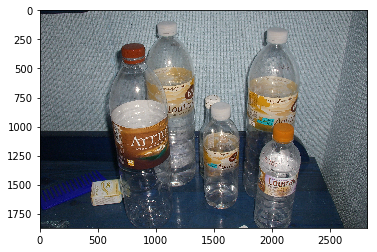

In [114]:
input_images = []
image = cv.imread("bottles/bottles1.jpg")
plt.imshow(image)
input_images.append(image)

In [0]:
outputs = (
    'num_detections',
    'detection_classes',
    'detection_scores',
    'detection_boxes',
)

In [0]:
labels = {}
with open("labels.txt", "r") as f:
  for name in f:
    key, _, value = name.partition(':')
    value, _, _ = value.partition('\n')
    labels[key] = value

In [0]:
with tf.Session() as sess:
  sess.graph.as_default()
  tf.import_graph_def(graph_def, name="")
  
  detections = sess.run(
      [sess.graph.get_tensor_by_name(f'{op}:0') for op in outputs],
      feed_dict={ 'image_tensor:0': input_images }
  )

In [0]:
num_detections = detections[0]
detection_classes = detections[1]
detection_scores = detections[2]
detection_boxes = detections[3]

In [117]:
num_detections[0]

9.0

In [118]:
for classes in detection_classes[0]:
  if classes != 1:
    print(labels[str(int(classes))])

 dining table
 bottle
 bottle
 bottle
 bottle
 bottle
 bottle
 cup
 cup


In [119]:
for i in range(int(num_detections[0])):
  print(detection_scores[0][i])

0.7280911
0.6367185
0.5996017
0.58707744
0.57075185
0.44478288
0.4135549
0.3642177
0.3523149


In [125]:
image_copy = np.copy(input_images[0])

height = image_copy.shape[0]
width = image_copy.shape[1]

cropped_images = []
cropped_count = 0

for x in range(0,int(num_detections)):
  if detection_scores[0][x] >= 0.4:
    left = int(width*detection_boxes[0][x][1])
    top = int(height*detection_boxes[0][x][0])
    right = int(width*detection_boxes[0][x][3])
    bottom = int(height*detection_boxes[0][x][2])

    cropped = image_copy[top:bottom, left:right]
    cv.imwrite("{}{}".format(labels[str(int(detection_classes[0][x]))], x+1) + '.png', cropped)
#     cropped = cv.resize(cropped, (224,224))
    cropped_images.append(cropped)
    cropped_count += 1

if cropped_count == 0:
  print("Use another image")
else:
  print("Number of confident detections: {}".format(cropped_count))

Number of confident detections: 7


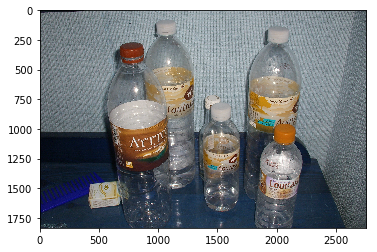

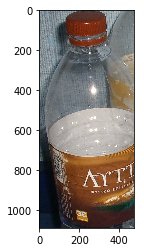

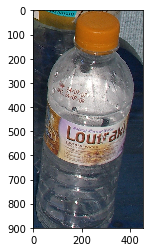

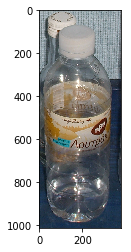

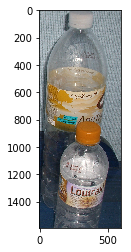

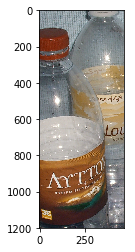

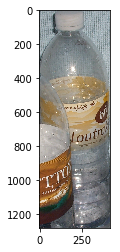

In [126]:
for images in cropped_images:
  plt.imshow(images)
  plt.show()

In [15]:
import keras
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNet(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0712 18:26:33.003375 140408393975680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 18:26:33.005166 140408393975680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 18:26:33.016333 140408393975680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecate

17227776/17225924 [==============================] - 0s 0us/step


In [16]:
from keras.models import Model

model = Model(inputs=base_model.input, output=preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [0]:
for layer in model.layers[:20]:
  layer.trainable = False
for layer in model.layers[20:]:
  layer.trainable = True

In [0]:
with ZipFile('trashnet.zip', 'r') as zipObj:
  zipObj.extractall()

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255)

train_generator = train_datagen.flow_from_directory('trashnet',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 225 images belonging to 3 classes.


In [21]:
from keras.optimizers import Adam

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=10)

W0712 18:26:44.557096 140408393975680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0712 18:26:44.760764 140408393975680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
7/7 [==============================] - 9s 1s/step - loss: 1.2083 - acc: 0.5982
Epoch 2/10
7/7 [==============================] - 2s 223ms/step - loss: 0.3261 - acc: 0.8106
Epoch 3/10
7/7 [==============================] - 1s 191ms/step - loss: 0.8399 - acc: 0.7696
Epoch 4/10
7/7 [==============================] - 1s 187ms/step - loss: 0.7342 - acc: 0.8379
Epoch 5/10
7/7 [==============================] - 1s 188ms/step - loss: 0.6720 - acc: 0.8652
Epoch 6/10
7/7 [==============================] - 1s 190ms/step - loss: 0.0651 - acc: 0.9727
Epoch 7/10
7/7 [==============================] - 1s 189ms/step - loss: 0.7466 - acc: 0.8516
Epoch 8/10
7/7 [==============================] - 1s 194ms/step - loss: 0.1250 - acc: 0.9818
Epoch 9/10
7/7 [==============================] - 1s 212ms/step - loss: 0.1182 - acc: 0.9732
Epoch 10/10
7/7 [==============================] - 1s 189ms/step - loss: 0.9396 - acc: 0.8607


In [122]:
for images in cropped_images:
  print(images.shape)

(1834, 2756, 3)


In [127]:
predictions = []
for images in cropped_images:
  test_image = images
  test_image = test_image/255
  test_image = np.expand_dims(test_image, axis=0)
  
  prediction = model.predict(test_image)
  predictions.append(prediction)
predictions

[array([[3.3487797e-21, 5.8527346e-18, 1.0000000e+00]], dtype=float32),
 array([[1.1505987e-21, 1.8121315e-18, 1.0000000e+00]], dtype=float32),
 array([[1.1918092e-22, 3.5426101e-19, 1.0000000e+00]], dtype=float32),
 array([[3.5685092e-23, 1.5271491e-19, 1.0000000e+00]], dtype=float32),
 array([[1.9464922e-19, 1.2531612e-16, 1.0000000e+00]], dtype=float32),
 array([[4.9881526e-18, 1.2830803e-15, 1.0000000e+00]], dtype=float32),
 array([[8.4261613e-20, 6.2918746e-17, 1.0000000e+00]], dtype=float32)]

In [32]:
print(train_generator.class_indices)

{'non-recyclable': 0, 'organic': 1, 'recyclable': 2}


Recyclable: 1.0


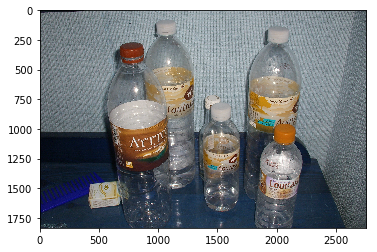

Recyclable: 1.0


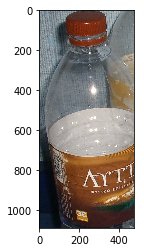

Recyclable: 1.0


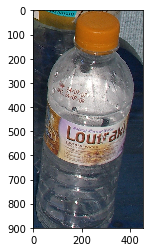

Recyclable: 1.0


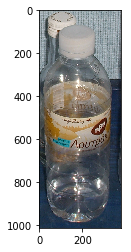

Recyclable: 1.0


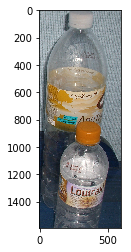

Recyclable: 1.0


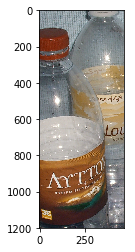

Recyclable: 1.0


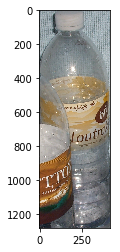

In [128]:
classes = ['Non-recyclable', 'Organic', 'Recyclable']

for i in range(len(predictions)):
  likely = predictions[i][0][0]
  likely_index = 0
  for j in range(len(predictions[i][0])):
    if predictions[i][0][j] > likely:
      likely = predictions[i][0][j]
      likely_index = j
  print('{}: {}'.format(classes[likely_index], likely))
  plt.imshow(cropped_images[i])
  plt.show()